## Sentence Similarity

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. There are many ways to compare similarities of 2 texts using traditional methods like edit distance as well as using deep learning neural networks. In this notebook, I compare some simple ways of computing sentence similarity using word vectors and investigate how they perform.


### Loading Data
#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [1]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


### Loading Embeddings
2 word embeddings were used for this experiment. Word2vec and Glove. 

#### Loading word2vec

In [3]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

#### Loading Glove
To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model. 

In [4]:
from embeddings.load_embeddings import load_glove
glove = load_glove("/data/glove/glove.840B.300d.txt")

#### Loading Frequencies
To weight the word vectors we need frequency stat. For that we used word frequencies that have been collected from Wikipedia. 

In [5]:
from utility.frequency_loader import load_frequencies, load_doc_frequencies

frequency = load_frequencies("/data/frequencies/frequencies.tsv")
doc_frequency = load_doc_frequencies("/data/frequencies/doc_frequencies.tsv")

### Vector Average
As our first similarity measure we are going to use vector average. Then take the embeddings of the words and calcluate the average to get a vector for the sentence. There are few benchmarks we created.
1. Calculating the average considering all the words. 
2. Calculating the average removing stop words.
3. Calculating the average while weighting the words with inverse document frequency.
4. Calculating the average while weighting the words with inverse document frequency and removing the stop words. 

These experiments were done using both word2vec and Glove. 

In [6]:
import functools as ft
from preprocessing.normalize import normalize
from matrices.avg_embeddings import run_avg_benchmark
from utility.run_experiment import run_experiment
import pandas as pd
import matplotlib.pyplot as plt


benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-W2V-TFIDF-STOP",ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequency)),
              ("AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False)),
              ("AVG-GLOVE-STOP", ft.partial(run_avg_benchmark, model=glove, use_stoplist=True)),
              ("AVG-GLOVE-TFIDF", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-GLOVE-TFIDF-STOP",ft.partial(run_avg_benchmark, model=glove, use_stoplist=True, doc_freqs=doc_frequency))]


Method was tested for SICK dataset. Only the training sample was used. Pearson Correlation and Spearman Correlation was used between the actual similarity and predicted similarity to evaluate the benchmark. 

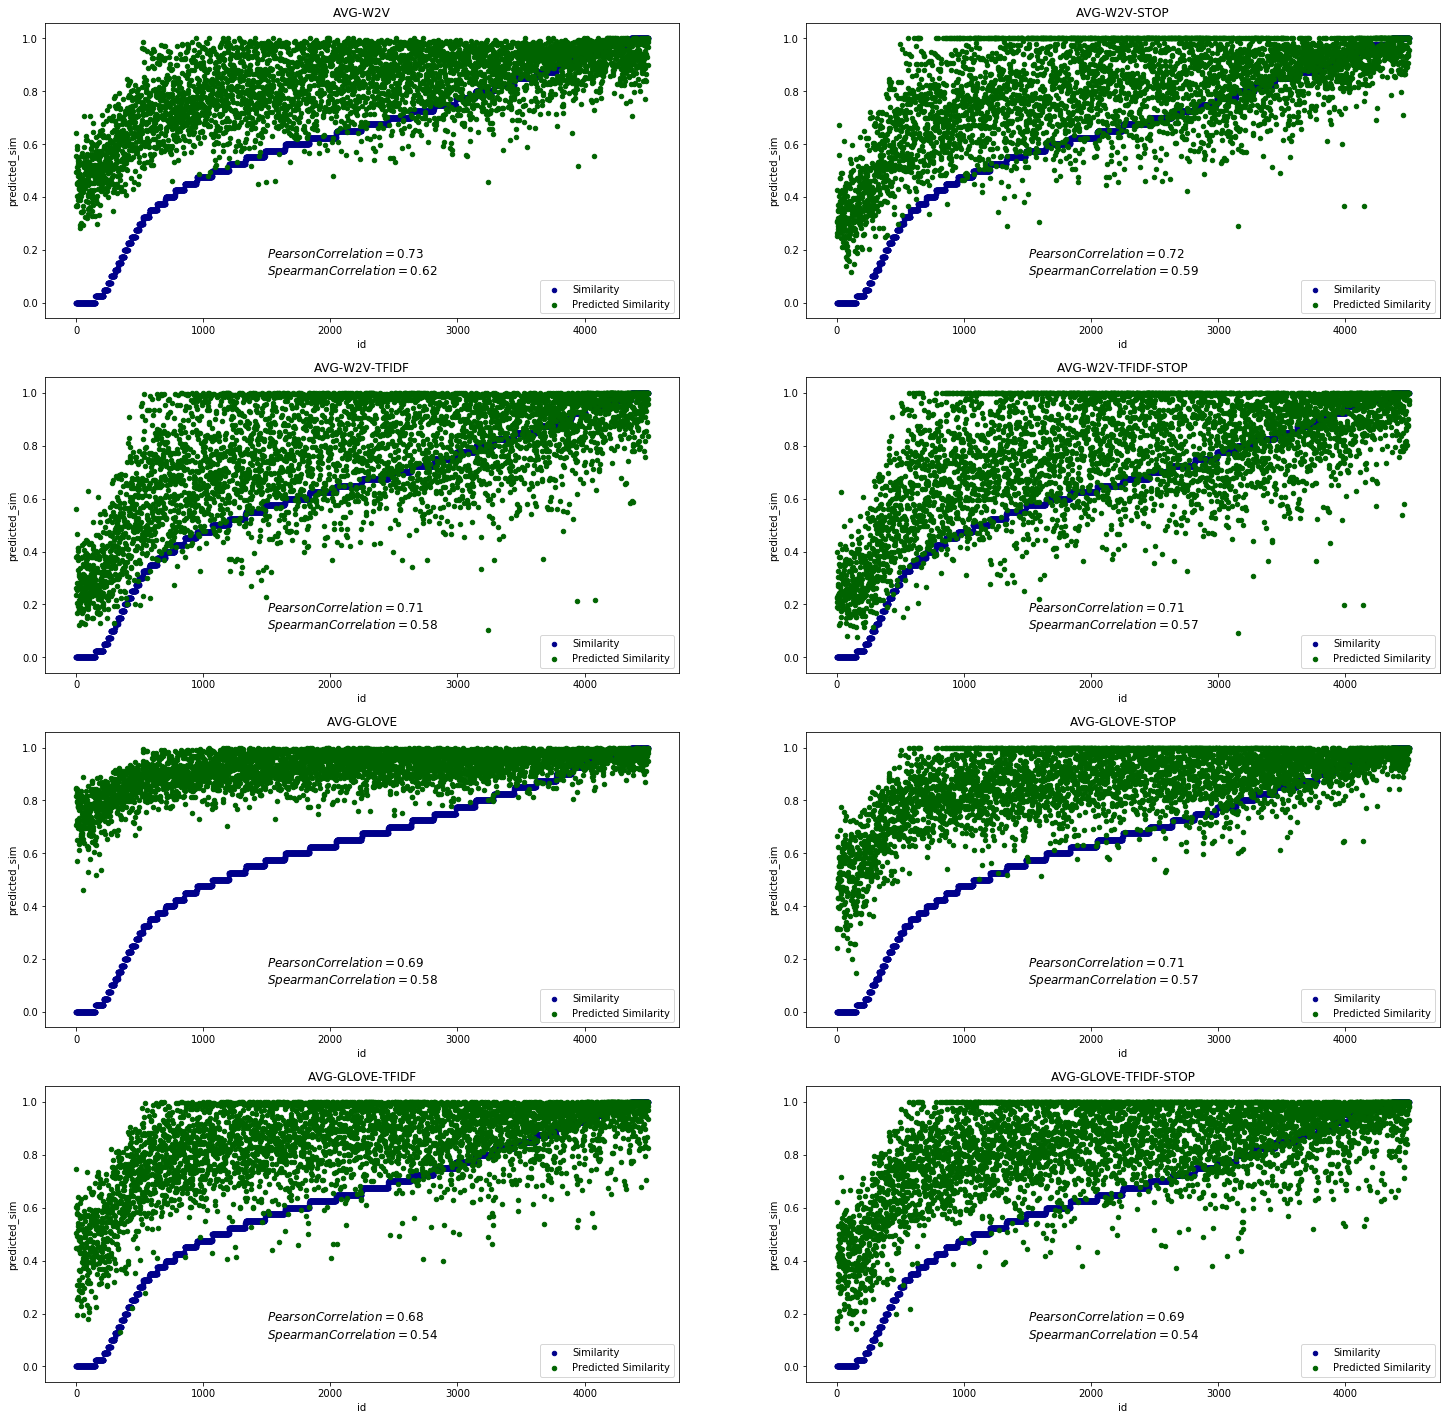

In [7]:
import scipy


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0.1, textstr, fontsize=12)



The word2vec models tend to perform better than the Glove models. From word2vec models also taking the average without removing stop words and without using tf-idf gave the best performance to SICK dataset. Let's see the sentences that average word2vec model got totally differently. 

In [8]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values

sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]                                    

,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
2350,5251,Nobody is playing with a toad,A man is playing the trumpet,0.000,NEUTRAL,0.705554,125,0.705554
4404,9776,A boy wearing a striped shirt is running baref...,A woman is wearing a blue helmet and is riding...,0.000,NEUTRAL,0.705277,31,0.705277
2585,5737,A man is eating,A woman is sleeping,0.025,NEUTRAL,0.712331,163,0.687331
3860,8569,A black dog and a small white and black dog ar...,A black cat and a small white and black cat ar...,0.300,NEUTRAL,0.985079,500,0.685079
2568,5691,The person is playing with a skull,The man is playing the guitar,0.050,NEUTRAL,0.730141,219,0.680141
4493,9984,Two dogs are playing on the beach,Two people are driving a jeep and a lady is si...,0.000,NEUTRAL,0.678752,69,0.678752
2570,5694,The man is not playing the guitar,The man is playing with a skull,0.100,NEUTRAL,0.775704,276,0.675704
715,1626,The man is playing a piano,A guy is cheerfully playing with a footbag,0.075,NEUTRAL,0.745142,259,0.670142
266,631,The man is tossing a kid into the swimming poo...,A kid swimming in the ocean is tossing a coin ...,0.300,NEUTRAL,0.964954,502,0.664954
689,1573,A man is playing the guitar,A person is listening to a trumpet playing,0.125,NEUTRAL,0.781657,320,0.656657


In most of the sentences when the word order is difference it gives a high similarity score. And it certainly doesn't take the difference beween phrases like dog, cat and man woman even though it gives completely different meanings. 

Method was tested using STS data set. Only the dev sample was used. Pearson Correlation and Spearman Correlation was calcluated as before

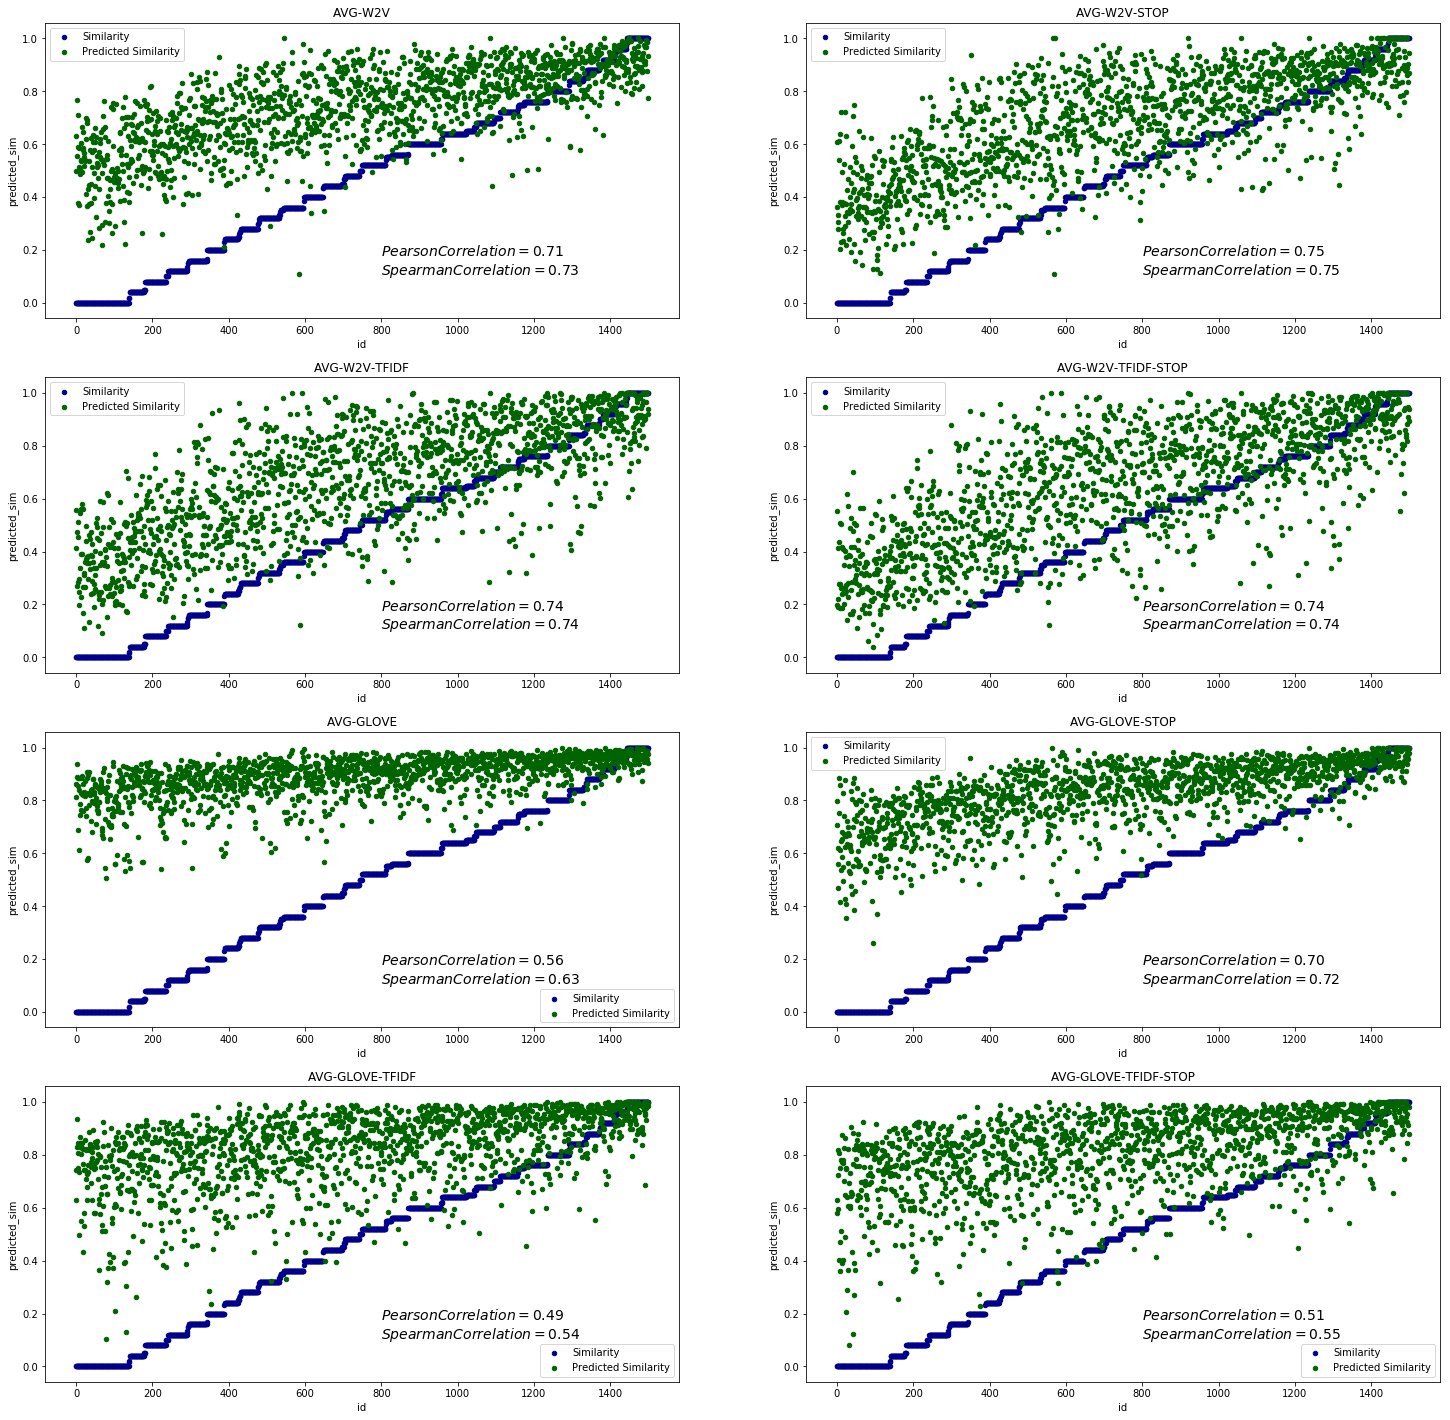

In [9]:
import scipy


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(800, 0.1, textstr, fontsize=14)



With STS Data set also Word2vec models perform better than Glove. Methods involving word2vec didn't have much difference in the corerelation in predictions and actual value, but from them 4th approach worked better this time. Let's consider the sentences it completely got wrong. 

In [10]:
import math
import numpy as np

sims, topic = run_experiment(sts_dev, benchmarks[3])
sts_dev['predicted_sim'] = pd.Series(sims).values

sts_dev["diff"] = np.sqrt((sts_dev["predicted_sim"] - sts_dev["sim"])**2)

sts_dev = sts_dev.sort_values("diff", ascending=False)
sts_dev[:10]    

,sent_1,sent_2,sim,predicted_sim,id,diff
533,There is a young girl.,There is a young boy with the woman.,0.20,0.932225,366,0.732225
1423,6.4-magnitude quake strikes off Indonesia,6.9-magnitude quake strikes off Russia's Kuril...,0.20,0.920009,377,0.720009
1398,"5 killed, 50 injured in Pakistan blast","3 killed, 138 injured in Boston blasts: media",0.16,0.877956,301,0.717956
465,A man wearing US flag boxer shorts is standing...,A woman wearing a white shirt stands on the st...,0.00,0.702269,37,0.702269
155,Three men are dancing.,Women are dancing.,0.26,0.960167,428,0.700167
803,I would recommend asking questions in a way th...,Would you be concerned with the mind changing ...,0.08,0.744766,215,0.664766
1254,Saudi gas truck blast kills at least 22,Nigeria church blast kills at least 12,0.12,0.781738,247,0.661738
936,I don't think we have a solid theory of mammal...,The short answer is that evolution couldn't cr...,0.16,0.810511,296,0.650511
612,The child is the woman's kid.,There is a boy and a girl.,0.16,0.806808,307,0.646808
492,A skateboarder jumps off the stairs.,A dog jumps off the stairs.,0.16,0.805102,342,0.645102


The errors we discussed in the previous section appears here also. 

### Word Mover's Distance
Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. 

In [11]:
from matrices.word_movers_distance import run_wmd_benchmark

benchmarks = [("WMD-W2V", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=False)), 
              ("WMD-W2V-STOP", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=True)), 
              ("WMD-GLOVE", ft.partial(run_wmd_benchmark, model=glove, use_stoplist=False)), 
              ("WMD-GLOVE-STOP", ft.partial(run_wmd_benchmark, model=glove, use_stoplist=True)) ]

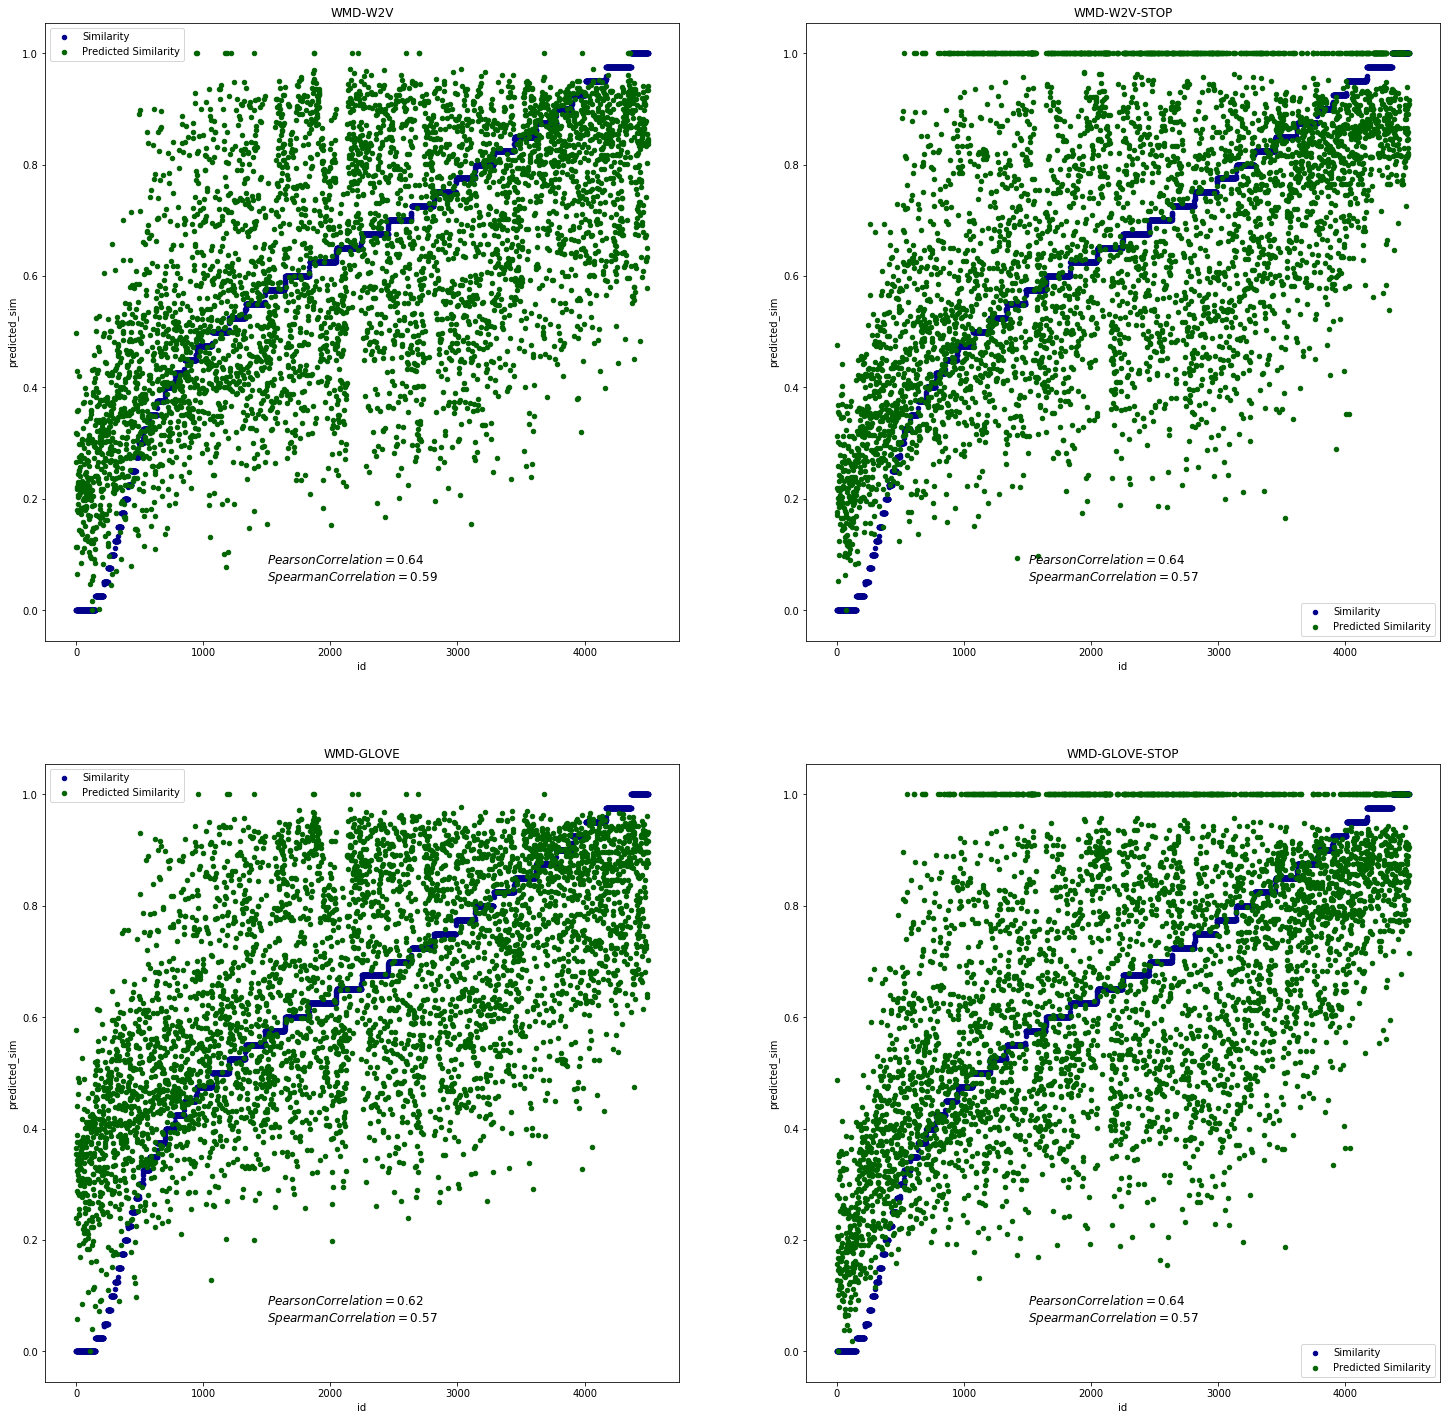

In [12]:
import scipy


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 4):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0.05, textstr, fontsize=12)



It didn't perform better than average word2vec method. Analyzing the best performing benchmark in this model, 

In [13]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values
sick_train = normalize(sick_train, ["predicted_sim"])
sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]      

,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
801,1822,A cook is slicing some bell peppers,An orange pepper is being diced up by a person,0.775,NEUTRAL,0.154972,3053,0.620028
3329,7399,A man and a child are kayaking through gentle ...,A yellow kayak is being ridden by a man and a ...,0.850,NEUTRAL,0.238696,3514,0.611304
1311,2952,The woman is penciling on eyeshadow,A woman is applying cosmetics to her eyelid,0.925,ENTAILMENT,0.319846,3902,0.605154
3860,8569,A black dog and a small white and black dog ar...,A black cat and a small white and black cat ar...,0.300,NEUTRAL,0.897856,519,0.597856
4258,9473,A young boy is sitting in a bathing suit and w...,A kid is sitting wearing swim gear,0.850,ENTAILMENT,0.258639,3475,0.591361
266,631,The man is tossing a kid into the swimming poo...,A kid swimming in the ocean is tossing a coin ...,0.300,NEUTRAL,0.890257,521,0.590257
803,1825,The person is dicing up a pepper which is orange,A cook is slicing some bell peppers,0.825,NEUTRAL,0.234789,3357,0.590211
3357,7462,A rider is surfing the wave,A man is performing a trick on a surfboard in ...,0.850,NEUTRAL,0.262100,3527,0.587900
401,920,Two people are kissing near a crowd,A lady is being kissed by a man,0.775,NEUTRAL,0.206332,3072,0.568668
3045,6731,A child is making a snow ball,A child in orange is playing outdoors with a s...,0.850,ENTAILMENT,0.286478,3590,0.563522


The problems that we saw in the average word2vec appears here also. Other than that this method tends to give bad results when the sentence length is different. 

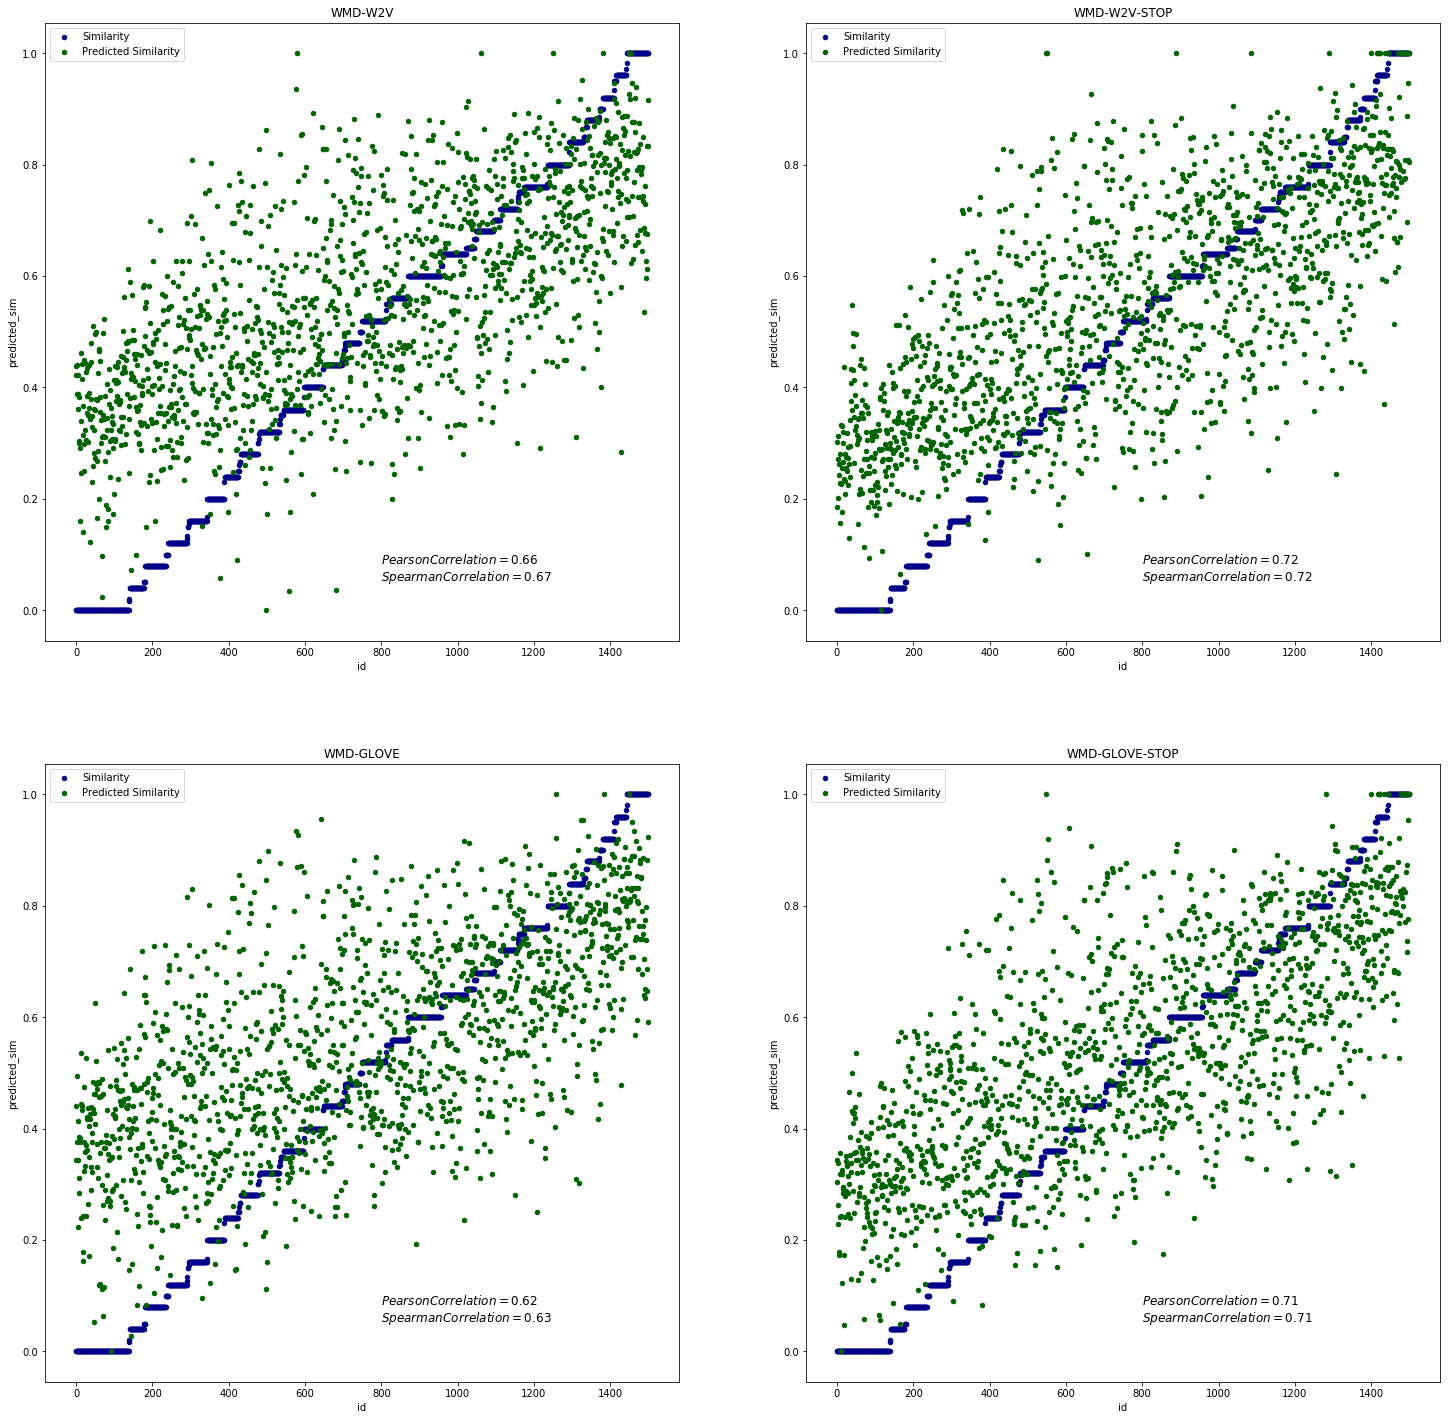

In [14]:

import scipy


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 4):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(800, 0.05, textstr, fontsize=12)

Removing stop words benchmark was good in this dataset. However it doesn't out perform the average word2vec method

### Smooth Inverse Frequency
Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem.

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by a/a+p(w), where a is a parameter that is set to 0.001 by default, and p(w) is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc.

In [15]:
from matrices.smooth_inverse_frequency import run_sif_benchmark


benchmarks = [("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequency, model=word2vec, use_stoplist=False)),
              ("SIF-GLOVE", ft.partial(run_sif_benchmark, freqs=frequency, model=glove, use_stoplist=False))]

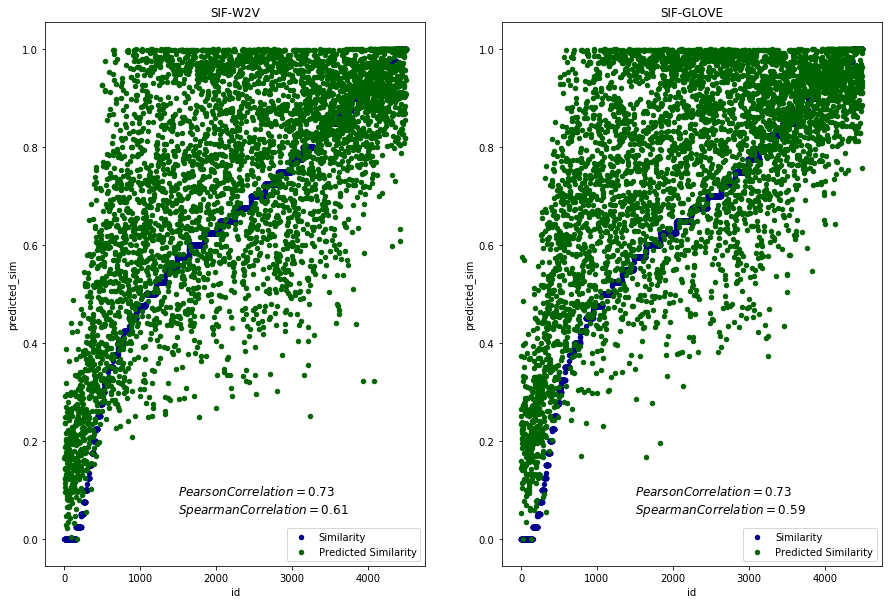

In [16]:
import scipy


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

The performance come close to Average word2vec method. Analyzing it more with sentences it got completely wrong. 

In [17]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values
sick_train = normalize(sick_train, ["predicted_sim"])
sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]  

,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
2919,6447,A small boy in a yellow shirt is laughing on t...,There is no small boy in a yellow shirt laughi...,0.325,CONTRADICTION,0.976426,564,0.651426
1935,4354,A jet is not flying,A jet is flying,0.350,CONTRADICTION,0.997666,591,0.647666
704,1604,The man is typing on a machine used for stenog...,The man is operating a stenograph,0.950,ENTAILMENT,0.321804,4136,0.628196
266,631,The man is tossing a kid into the swimming poo...,A kid swimming in the ocean is tossing a coin ...,0.300,NEUTRAL,0.927725,515,0.627725
3860,8569,A black dog and a small white and black dog ar...,A black cat and a small white and black cat ar...,0.300,NEUTRAL,0.926484,513,0.626484
3571,7917,A dog is not running towards a ball,A dog is running towards a ball,0.375,CONTRADICTION,0.997765,692,0.622765
2972,6567,A woman is wearing a blue helmet and is riding...,There is no woman wearing a blue helmet and ri...,0.375,CONTRADICTION,0.989292,684,0.614292
4010,8924,A little dog is running on the sand,No little dog is running on the sand,0.375,CONTRADICTION,0.979982,653,0.604982
367,855,A black and a white dog are joyfully running o...,A black person in white is joyfully running wi...,0.350,NEUTRAL,0.953838,620,0.603838
705,1606,The man is operating a stenograph,A man is typing on a machine used for stenography,0.925,ENTAILMENT,0.321598,4001,0.603402


Some sentences overlap with the failed sentences in average word2vec model but notably the model failed to differentiate negativity. 

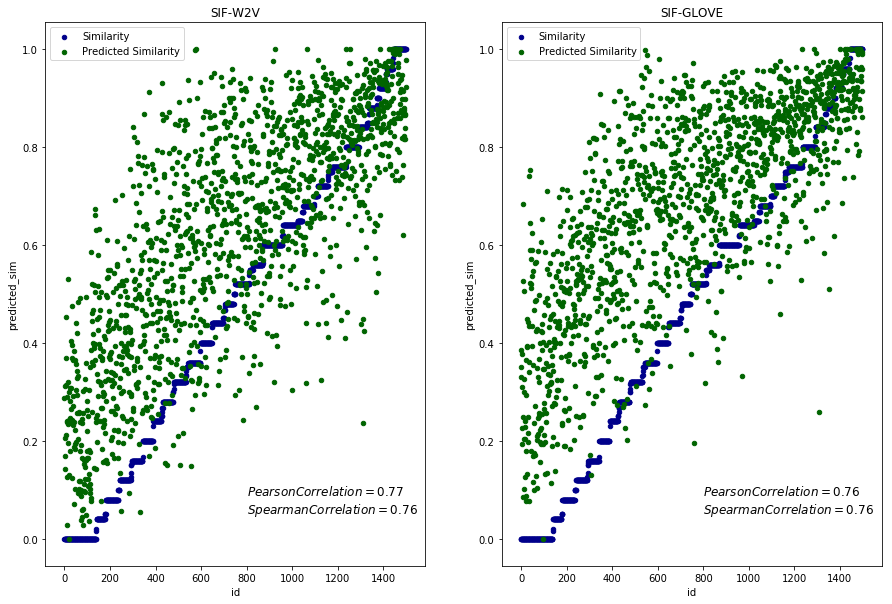

In [18]:
import scipy


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(800, 0.05, textstr, fontsize=12)

Smooth inverse frequency performs slightly better in this dataset than average model. Taking the sentences that performed bad with this model. 

In [19]:
import math
import numpy as np

sims, topic = run_experiment(sts_dev, benchmarks[0])
sts_dev['predicted_sim'] = pd.Series(sims).values

sts_dev["diff"] = np.sqrt((sts_dev["predicted_sim"] - sts_dev["sim"])**2)

sts_dev = sts_dev.sort_values("diff", ascending=False)
sts_dev[:10]   

,sent_1,sent_2,sim,predicted_sim,id,diff
794,It would be unusual for a snake to attack a st...,"I'm no herpetologist, but in my experience, sn...",0.84,0.129292,1309,0.710708
533,There is a young girl.,There is a young boy with the woman.,0.20,0.899228,347,0.699228
155,Three men are dancing.,Women are dancing.,0.26,0.920898,428,0.660898
1398,"5 killed, 50 injured in Pakistan blast","3 killed, 138 injured in Boston blasts: media",0.16,0.818150,325,0.658150
1423,6.4-magnitude quake strikes off Indonesia,6.9-magnitude quake strikes off Russia's Kuril...,0.20,0.848909,370,0.648909
1369,Stocks close 0.39% higher,Stocks close 2.47% higher,0.36,1.000000,549,0.640000
507,A man is carrying a canoe with a dog.,A dog is carrying a man in a canoe.,0.36,0.998965,546,0.638965
492,A skateboarder jumps off the stairs.,A dog jumps off the stairs.,0.16,0.795213,329,0.635213
664,I've found an additional concept that may be r...,According to current models of human concept l...,0.00,0.628981,41,0.628981
1000,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.16,0.783568,320,0.623568


### InferSent
InferSent is a pre-trained encoder that produces sentence embeddings. More particularly, it is a BiLSTM with max pooling that was trained on the SNLI dataset, 570k English sentence pairs labelled with one of three categories: entailment, contradiction or neutral. InferSent was developed and trained by Facebook Research.

In [20]:
import torch
from utility.infer_sent.models import InferSent


MODEL_PATH = "/data/InferSent/encoder/infersent1.pkl"
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 1}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))
GLOVE_PATH = '/data/glove/glove.840B.300d.txt'
model.set_w2v_path(GLOVE_PATH)


In [21]:
from matrices.infer_sent import run_inf_benchmark
import functools as ft

benchmarks = [ ("INF", ft.partial(run_inf_benchmark, infersent=model))]


Found 2253(/2257) words with w2v vectors
Vocab size : 2253


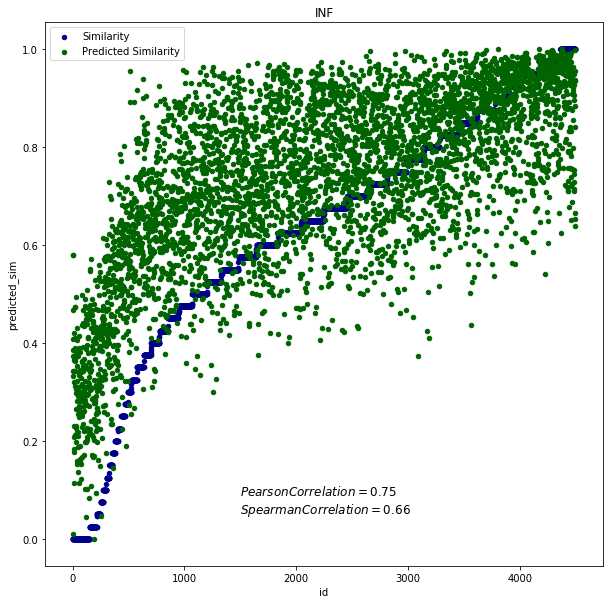

In [22]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
import pandas as pd
from utility.run_experiment import run_experiment

sick_train = normalize(sick_train, ["sim"])
for i in range(0, 1):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    
    ax = sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, figsize=(10,10));
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=ax);
    ax.text(1500, 0.05, textstr, fontsize=12)



Infersent model performed beter than all the models we checked. Checking the sentences it got wrong. 

In [23]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values
sick_train = normalize(sick_train, ["predicted_sim"])
sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]  

Found 2253(/2257) words with w2v vectors
Vocab size : 2253


,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
3860,8569,A black dog and a small white and black dog ar...,A black cat and a small white and black cat ar...,0.300,NEUTRAL,0.954360,516,0.654360
4088,9083,A brown and black dog is pointing the nose upw...,A black and brown cat is eyeing a fly,0.125,NEUTRAL,0.727706,328,0.602706
1853,4185,A dog is playing with a toy,A kid is playing with a toy dog,0.325,NEUTRAL,0.915699,575,0.590699
266,631,The man is tossing a kid into the swimming poo...,A kid swimming in the ocean is tossing a coin ...,0.300,NEUTRAL,0.890392,517,0.590392
367,855,A black and a white dog are joyfully running o...,A black person in white is joyfully running wi...,0.350,NEUTRAL,0.938081,628,0.588081
4404,9776,A boy wearing a striped shirt is running baref...,A woman is wearing a blue helmet and is riding...,0.000,NEUTRAL,0.579501,5,0.579501
2919,6447,A small boy in a yellow shirt is laughing on t...,There is no small boy in a yellow shirt laughi...,0.325,CONTRADICTION,0.890468,546,0.565468
3235,7164,A black climber is rocking a dog,The black dog is climbing on a rock,0.225,NEUTRAL,0.784414,424,0.559414
719,1632,A woman is breaking two eggs in a bowl,A woman is bowling two eggs to a break dancer,0.250,NEUTRAL,0.801164,459,0.551164
2972,6567,A woman is wearing a blue helmet and is riding...,There is no woman wearing a blue helmet and ri...,0.375,CONTRADICTION,0.925473,656,0.550473


The results show that this model also predict similarity wrong when the same words are rearranged. 
Testign the same model on STS data set. 

Found 7020(/7191) words with w2v vectors
Vocab size : 7020


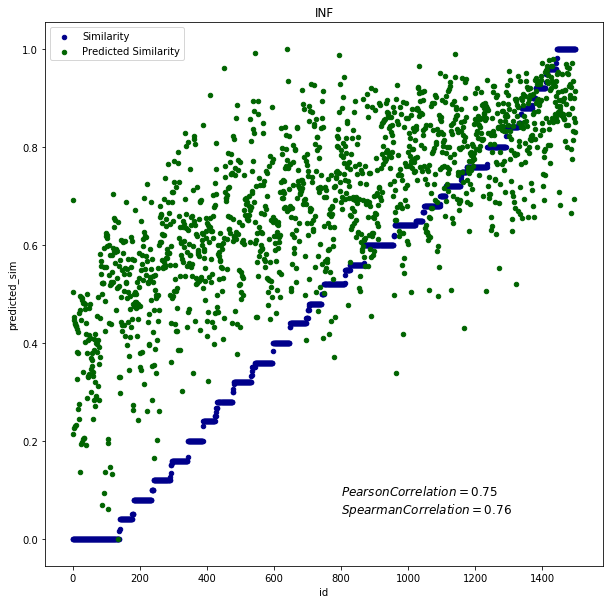

In [26]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
import pandas as pd
from utility.run_experiment import run_experiment

sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 1):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    
    ax = sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, figsize=(10,10));
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=ax);
    ax.text(800, 0.05, textstr, fontsize=12)


For STS Data set, the model couldn't perform better than Smooth Inferse Frequency Model. Checking the sentences it got wrong. 

In [25]:
import math
import numpy as np

sims, topic = run_experiment(sts_dev, benchmarks[0])
sts_dev['predicted_sim'] = pd.Series(sims).values

sts_dev["diff"] = np.sqrt((sts_dev["predicted_sim"] - sts_dev["sim"])**2)

sts_dev = sts_dev.sort_values("diff", ascending=False)
sts_dev[:10]   

Found 7020(/7191) words with w2v vectors
Vocab size : 7020


,sent_1,sent_2,sim,predicted_sim,id,diff
1499,New video shows US police officers beating men...,New York police officer critically wounded in ...,0.00,0.781860,15,0.781860
908,Even though the question has been answered I w...,"I don't know if I should say this, but if your...",0.00,0.760231,3,0.760231
664,I've found an additional concept that may be r...,According to current models of human concept l...,0.00,0.757647,102,0.757647
1436,Food poisoning kills at least 20 children in I...,Baghdad cafe bombing kills at least 38,0.00,0.754604,73,0.754604
793,An embolism in a medical context refers to any...,Here is an interesting article on wikipedia to...,0.00,0.750967,138,0.750967
852,"I have no idea why it is voted up, but Rex Ker...","It's a tautology, but the mapping between logi...",0.00,0.744365,89,0.744365
632,"If you have access to it, you can very easily ...",You can have a look at the arXiv cultoromics w...,0.04,0.779757,147,0.739757
592,A guy and a girl are rock climbing with backpa...,Two boys are riding on a toy with a blonde gir...,0.00,0.735476,40,0.735476
859,The question of time is an incredibly difficul...,"wikipedia, as much as it is a supposedly self ...",0.00,0.733792,1,0.733792
670,Presumably the decision of drivers to slow dow...,"This short talk deals with issues of ""cheating...",0.00,0.733656,126,0.733656


### Conclusions

1. When you're computing sentence similarity, word2vec embeddings are a safer choice than GloVe embeddings.
2. Smooth Inverse Frequency and InferSent Models performed better. But no model was able to go beyong 0.77 Correlation
